In [1]:
import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
%load_ext autoreload
%autoreload 2
from scipy import stats
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.model_selection import KFold, LeaveOneOut
import random
import hyperalignment as hyp
from brainiak.funcalign import srm
from simulate_correlated_data import SimulatedCorrelatedData
from demo_data_helpers import (load_rsfmri, load_sherlock_movie, 
                                compute_connectivity_matrix, plot_3d_datasets, 
                               plot_3d_trajectories, load_sherlock_labels)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
random.seed(4)
np.random.seed(4)
%matplotlib inline

# Hyperalignment

## Simulated timeseries data
First, we're going to create simulated datasets with a controlled correlational structure. Each dataset has the same number of samples and features and a set between-feature correlation, and added normally distributed noise. Then, across datasets, the same features are correlated to a lesser degree -- mimicing within-participant vs. between-participant correlation structure. 

In [2]:
# Create datasets with the following parameters
n_participants, n_samples, n_features = 12, 100, 3
within_corr = 0.8
between_corr = 0.2
noise=10

simulator = SimulatedCorrelatedData(n_datasets=n_participants, 
                        n_samples=n_samples, 
                        n_features_measured=n_features,
                        n_features_latent=2,
                       noise_sigma=noise,
                       intra_ds_corr=within_corr,
                       inter_ds_corr=between_corr,
                       verbose=1)
dss = simulator.generate()
dss=dss[1:]

Generating 12 datasets with 100 samples each
Each dataset has 3 measured features derived from 2 latent features
Target intra-dataset correlation: 0.8, inter-dataset correlation: 0.2
Generating latent features with the specified correlation structure...
Average intra-dataset correlation in latent features: 0.7937 (target: 0.8000)
Average inter-dataset correlation in latent features: 0.1671 (target: 0.2000)

Projecting latent features to measured features...

Verifying correlation structure of measured features...
Average intra-dataset correlation in measured features: 0.0246 (target: 0.8000)
Average inter-dataset correlation in measured features: 0.0021 (target: 0.2000)


Let's visually verify the structure of these datasets. In the matrix, features within-dataset are along the diagonal -- so the first 20 features on the x,y axes belong to participant 1, and so on.

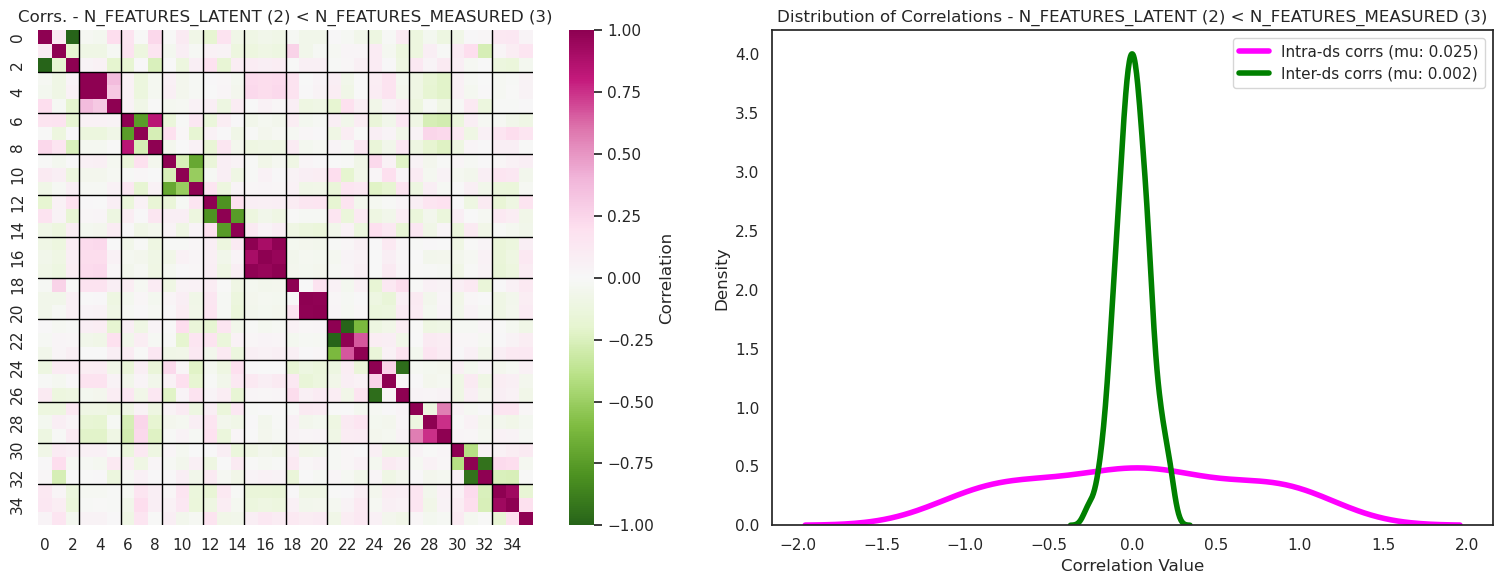

In [3]:
simulator.visualize()

Because these data are 3D, we can plot them for each participant, where each axis is feature, each participant is a color, and each point is a sample. We've included code to plot these as a) scatterplots and b) trajectories in the `demo_data_helpers` file, and will plot them here:

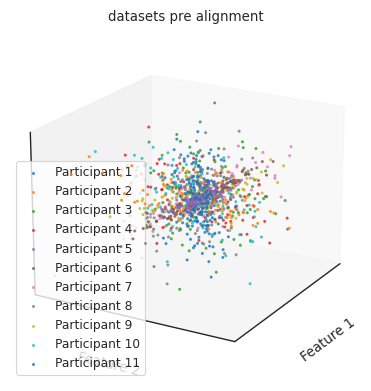

In [4]:
fig, ax = plot_3d_datasets(
        datasets=dss,
        view_angles=(20, 30),
    s=2,
    title='datasets pre alignment'
    )

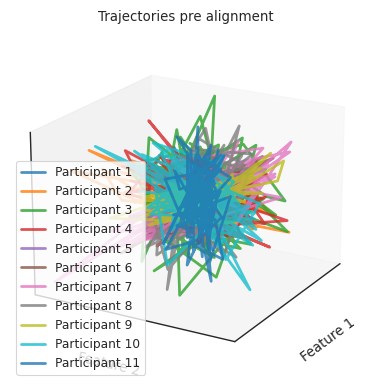

In [5]:
fig, ax = plot_3d_trajectories(
        trajectories=dss,
        view_angles=(20, 30),
    title='Trajectories pre alignment'
    )

As you can see, these datasets seem pretty misaligned along the axes of these three features. Now, let's try hyperaligning this data. Hyperalignment will find a high-dimensional template that captures similarities between the datasets, and derive transformations between the individual datasets to that high-dimensional template. 

In [6]:
# For now, let's use all the default settings
hyp_model = hyp.Hyperalignment(verbose=True)
hyp_model.fit(dss)
isc_results=hyp_model.evaluate_isc()

Normalizing data...
Iteration 1, disparity=0.8967
Iteration 2, disparity=0.8967
Iteration 3, disparity=0.8967
Iteration 4, disparity=0.8967
Iteration 5, disparity=0.8967
Iteration 6, disparity=0.8967
Iteration 7, disparity=0.8967
Iteration 8, disparity=0.8967
Iteration 9, disparity=0.8967
Iteration 10, disparity=0.8967
final average disparity: 0.8967
Pre-alignment ISC: 0.0122
Post-alignment ISC: 0.1280


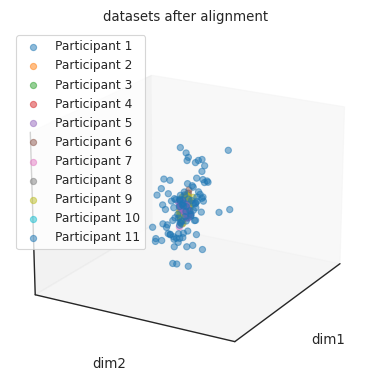

In [7]:
fig, ax = plot_3d_datasets(
        datasets=hyp_model.aligned_data,
    feature_names=['dim1','dim2','dim3'],
    title='datasets after alignment',alpha=0.5,
        view_angles=(20, 30)
    )

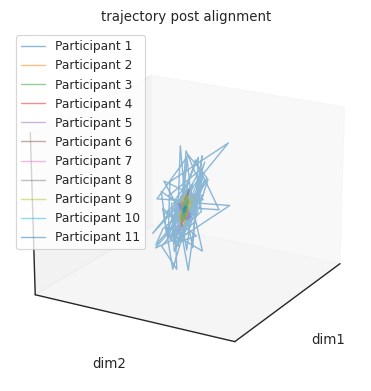

In [8]:
fig, ax = plot_3d_trajectories(
        trajectories=hyp_model.aligned_data,
        view_angles=(20, 30),
    feature_names=['dim1','dim2','dim3'],
        title='trajectory post alignment',alpha=0.5,
        linewidth=1             # Width of the trajectory lines
    )

## Movie timeseries data
Next we're going to look at data collected while 17 participants watched an episode of BBC's Sherlock in the scanner (accessed from : http://arks.princeton.edu/ark:/88435/dsp01nz8062179). These data were already preprocessed and extracted from an early visual ROI. We are going to demonstrate how to run hyperalignment with cross-validation on these data.

In [9]:
dss = load_sherlock_movie()
labels = load_sherlock_labels()
n_participants, n_trs, n_voxels = dss.shape # 16 participants ,1976 timepoints, 307 voxels
print(dss.shape, labels.shape)

(16, 1976, 307) (1976,)


### Split-half cross validation
For the first form of cross-validation, we are going to use one half of the timeseries, for all participants, to train the hyperalignment model and transformation matrices. Then, we are going to apply those transformation matrices to the second half of the data, and evaluate ISC and between-subject classification accuracy. Cross-validation like this would be used to evaluate that the transformations learned with hyperalignment aren't overfit to the data it received during training, but actually represent something generalizable about each participants' functional organization.

In [10]:
training_dss = dss[:, :n_trs//2, :] # training on first half
testing_dss = dss[:, n_trs//2:, :] # testing on second half
hyp_model = hyp.Hyperalignment(verbose=0)
hyp_model.fit(training_dss)

# Apply those transformations to the second half
testing_dss_aligned = hyp_model.transform(testing_dss)

In [11]:
testing_results = hyp_model._run_isc(testing_dss)
testing_results_aligned = hyp_model._run_isc(testing_dss_aligned)
training_results_dict=hyp_model.evaluate_isc()
training_results = training_results_dict['Pre-alignment']
training_results_aligned = training_results_dict['Post-alignment']

In [12]:
# Average results to get one per subject per split
r0 = np.mean(testing_results,axis=1)
r1 = np.mean(testing_results_aligned, axis=1)
r2 = np.mean(training_results, axis=1)
r3 = np.mean(training_results_aligned, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.ones(16), np.zeros(16), np.ones(16)]), 
              'training':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

#### Make sure that this implementation converges with the nltools package    

In [14]:
# Run the same analysis with nltools
from nltools.stats import procrustes
# take the template learned by the hyperalignment model -- which contains the iterative procedure not built into the nltools implementation
template = hyp_model.get_template()
hyperaligned_training_dss = hyp_model.aligned_data
nltools_aligned_dss = []
for dx in training_dss:
    # standardize the data
    dx -= np.mean(dx,axis=0)
    dx /= np.linalg.norm(dx)
    _,da,_,_,_ = procrustes(template, dx) # works to align arg2 to arg 1
    nltools_aligned_dss.append(da)

# now compare each aligned dataset
for i in range(len(training_dss)):
    print(f'participant {i+1} all close? = {np.allclose(hyperaligned_training_dss[i], nltools_aligned_dss[i])}')


participant 1 all close? = True
participant 2 all close? = True
participant 3 all close? = True
participant 4 all close? = True
participant 5 all close? = True
participant 6 all close? = True
participant 7 all close? = True
participant 8 all close? = True
participant 9 all close? = True
participant 10 all close? = True
participant 11 all close? = True
participant 12 all close? = True
participant 13 all close? = True
participant 14 all close? = True
participant 15 all close? = True
participant 16 all close? = True


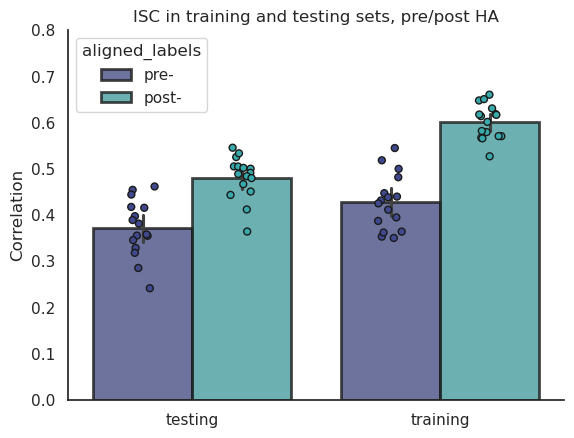

In [15]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=isc_results, x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title='ISC in training and testing sets, pre/post HA')
sns.despine()

What we see here is that hyperalignment improves how synchronized participants' brain responses are with one another. That improvement is greatest in the data that were used to train the hyperalignment (`training` on the x-axis), but the transformations also generalized -- when applied to unseen data (`testing` on the x-axis), we also saw a boost in synchrony.

In [16]:
def random_upsample_train_data(X_train, Y_train):
    '''
    Randomly upsamples training samples so that there are equal samples for each class 
    Helpful for balancing classification problems
    '''
    (unique, counts) = np.unique(Y_train, return_counts=True)
    goal = max(counts)
    train_indices = []
    for ind, classs in enumerate(unique):
        if counts[ind] != goal:
            num2add = goal - counts[ind]
            where_this_class = np.where(Y_train == classs)
            chosen_indices = list(random.choices(where_this_class[0], k=num2add)) + list(where_this_class[0])
            train_indices = train_indices + chosen_indices
        else:
            train_indices += list(np.where(Y_train == classs)[0])
    train_indices.sort()
    X_train = X_train[train_indices]
    Y_train = Y_train[train_indices]
    return X_train, Y_train

### Example of running between-subject classification with leave-one-out cross validation -- takes a very long time to run

In [ ]:
df=pd.DataFrame(columns=['fold','aligned','accuracy'])
label_subset = labels[n_trs//2:]
training_labels_orig = np.tile(label_subset, 15)
label_subset1=label_subset
folder=LeaveOneOut()
testing_dss_aligned=np.array(testing_dss_aligned)
testing_dss = np.array(testing_dss)
_, ns, nv = testing_dss.shape
kernel='rbf'
C=10
# between subject classification analysis 
for i,(train_idx,test_idx) in enumerate(folder.split(np.arange(16))):
    print(f'Fold {i}, testing on: {test_idx}')

    # train on all other subjects' data; test on held-out    
    clf_training, clf_testing = testing_dss[train_idx].reshape(len(train_idx)*ns,nv), testing_dss[test_idx].reshape(len(test_idx)*ns, nv)
    clf_training, training_labels = random_upsample_train_data(clf_training, training_labels_orig)

    clf_training_aligned, clf_testing_aligned = testing_dss_aligned[train_idx].reshape(len(train_idx)*ns,nv), testing_dss_aligned[test_idx].reshape(len(test_idx)*ns, nv)
    clf_training_aligned, training_labels = random_upsample_train_data(clf_training_aligned, training_labels_orig)

    print(f'reshaped data: {clf_training.shape}, {clf_testing.shape}, {clf_training_aligned.shape}, {clf_testing_aligned.shape}')
    svc_orig = svm.SVC(C=C, kernel=kernel,class_weight='balanced')
    svc_orig.fit(clf_training, training_labels)
    acc = svc_orig.score(clf_testing, label_subset1)
    print(f'orig={np.round(acc,3)}')
    df.loc[len(df)] = {'fold':i, 'aligned':'pre-', 'accuracy':acc}

    svc_align = svm.SVC(C=C, kernel=kernel, class_weight='balanced')
    svc_align.fit(clf_training_aligned, training_labels)
    acc_align = svc_align.score(clf_testing_aligned, label_subset1)
    df.loc[len(df)] = {'fold':i, 'aligned':'post-', 'accuracy':acc_align}
    print(f'aligned={np.round(acc_align,3)}')
    
    

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(2,4))
g=sns.barplot(data=df, x='aligned', 
              y='accuracy', 
              order=['pre-','post-'],
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)

g.set(xticklabels=['pre-','post-'], ylim=[0,1], xlabel='', 
      ylabel='accuracy', title='Between-subject classification')
sns.despine()

## Aligning RS-fMRI 

In [17]:
loaded_data=load_rsfmri(20, seed_region=10)

In [18]:
parcellated_data, region_data = np.array(loaded_data['parcellated_all']), np.array(loaded_data['region_all'])
n_timepoints = region_data.shape[1]
parcellated_split_0, region_split_0 = parcellated_data[:, :n_timepoints//2, :], region_data[:, :n_timepoints//2, :]
parcellated_split_1, region_split_1 = parcellated_data[:, n_timepoints//2:, :], region_data[:, n_timepoints//2:, :]

cnx_split0 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_0, region_split_0)]
cnx_split1 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T)) for p,r in zip(parcellated_split_1, region_split_1)]
print(np.shape(cnx_split0), np.shape(cnx_split1))

(20, 150, 67) (20, 150, 67)


In [19]:
# Train hyperalignment on the first half and transform the second half, and vice-versa
model_split0 = hyp.Hyperalignment(verbose=0)
model_split0.fit(cnx_split0)
aligned_cnx_split1 = model_split0.transform(cnx_split1)

model_split1 = hyp.Hyperalignment(verbose=0)
model_split1.fit(cnx_split1)
aligned_cnx_split0 = model_split1.transform(cnx_split0)

In [20]:
# evaluate reliability of connectivity across split-halves
def individual_differences_reliability(cnx0, cnx1):
    pcorr0 = compute_pairwise_corr(cnx0)
    pcorr1 = compute_pairwise_corr(cnx1)
    return np.corrcoef(pcorr0, pcorr1)[0,1]

# computes the correlation between pairs of participants' connectomes
def compute_pairwise_corr(c):
    n,s,t=np.array(c).shape
    c = np.array(c).reshape(n,s*t)
    corrs = pdist(c, 'correlation')
    return corrs

[Text(0.5, 1.0, 'split 1; split-half rel =0.591')]

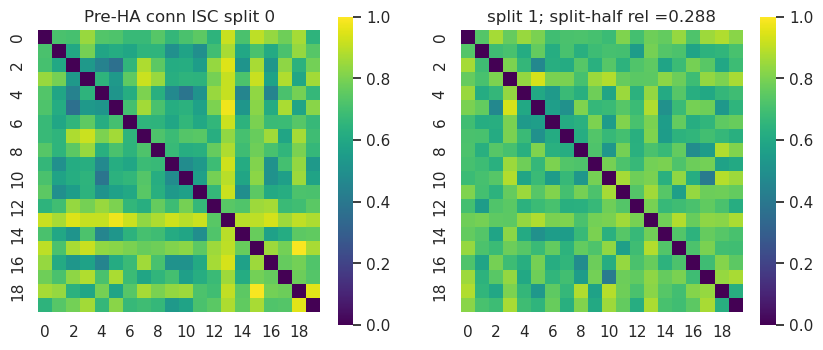

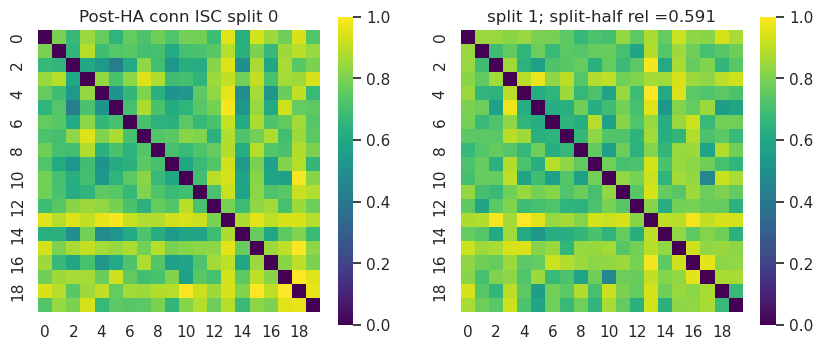

In [21]:
# Running reliability of individual differences across the split halves of data, 
# before and after hyperalignment

pcorr0 = squareform(compute_pairwise_corr(cnx_split0))
pcorr1 = squareform(compute_pairwise_corr(cnx_split1))

fig,ax = plt.subplots(1,2,figsize=(10,4))
r=individual_differences_reliability(cnx_split0, cnx_split1)
g=sns.heatmap(pcorr0, ax=ax[0], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title='Pre-HA conn ISC split 0')
g=sns.heatmap(pcorr1, ax=ax[1], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title=f'split 1; split-half rel ={np.round(r,3)}')


apcorr0 = squareform(compute_pairwise_corr(aligned_cnx_split0))
apcorr1 = squareform(compute_pairwise_corr(aligned_cnx_split1))
r=individual_differences_reliability(aligned_cnx_split0, aligned_cnx_split1)
fig,ax = plt.subplots(1,2,figsize=(10,4))
g=sns.heatmap(apcorr0, ax=ax[0], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title='Post-HA conn ISC split 0')
g=sns.heatmap(apcorr1, ax=ax[1], vmin=0, vmax=1, cmap='viridis', square=True)
g.set(title=f'split 1; split-half rel ={np.round(r,3)}')


So what we see here is that the relationships between participants' connectivity information (i.e., how different participants' functional connectomes are from one another) are much more reliable after hyperalignment than before hyperalignment (pre HA: $r=0.288$ versus post HA: $r=0.591$). These data were hyperaligned across split-halves (i.e. training the hyperalignment model on connectivity matrices computed from the first half of the resting state timeseries and using it to transform the second half, and vice-versa, as in our recent [J. Neurosci paper](https://ericabusch.github.io/files/abcd_ha.pdf)). 

# Shared response model

## Simulated timeseries data

In [22]:
def run_isc(X):
    '''
    Intersubject correlation analysis: 
    compares each subject's timeseries with the average of all other subjects' timeseries
    Measure of "synchrony" over time across brains, which should be improved by functional alignment
    '''
    if len(np.shape(X)) == 2:
        X = X[:,:,np.newaxis]
    results = np.zeros((len(X), X[0].shape[-1]))
    for i in range(len(X)):
        test = X[i]
        tr_idx = np.setdiff1d(np.arange(len(X)),i)
        train = np.mean(np.array([X[j] for j in tr_idx]), axis=0)
        # get correlation at each feature
        cmat = cdist(test.T, train.T, 'correlation')
        corrs = [1-cmat[i,i] for i in range(cmat.shape[0])]
        results[i]= corrs
    return results

In [23]:
# Create datasets with the following parameters
n_participants, n_samples, n_features = 12, 100, 20
within_corr = 0.8
between_corr = 0.2
noise=0.1

simulator = SimulatedCorrelatedData(n_datasets=n_participants, 
                        n_samples=n_samples, 
                        n_features_measured=n_features,
                        n_features_latent=2,
                       noise_sigma=noise,
                       intra_ds_corr=within_corr,
                       inter_ds_corr=between_corr,
                       verbose=0)
dss = simulator.generate()

# Fit model with 5 features
srm_model = srm.SRM(features=5)

# Have to reshape to be [subjects, features, samples] instead
srm_model.fit([d.T for d in dss])

# Transform the data
srm_data = srm_model.transform([d.T for d in dss])
srm_data = [d.T for d in srm_data]
iscs_srmed = np.mean(run_isc(srm_data),axis=1)
iscs_pre = np.mean(run_isc(dss),axis=1)

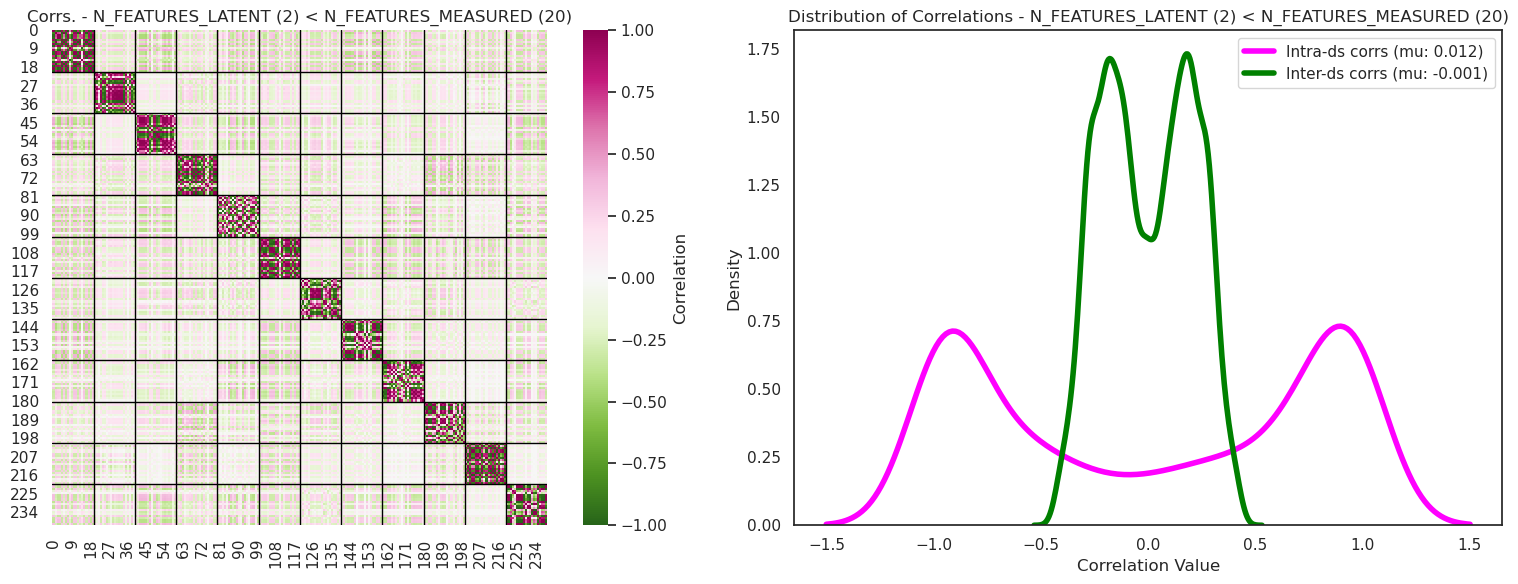

In [24]:
simulator.visualize()

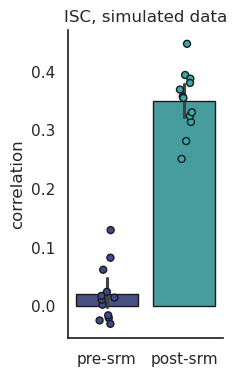

In [25]:
fig,ax=plt.subplots(1,1,figsize=(2,4))

g=sns.barplot([iscs_pre, iscs_srmed], palette='mako', ec='k')
g=sns.stripplot([iscs_pre, iscs_srmed], palette='mako', dodge=False, edgecolor='k', 
                linewidth=1,)
g.set(xticks=[0,1], xticklabels=['pre-srm','post-srm'], ylabel='correlation', title='ISC, simulated data')
sns.despine()

## Movie timeseries data

In [26]:
dss = load_sherlock_movie()
labels = load_sherlock_labels()
n_participants, n_trs, n_voxels = dss.shape # 16 participants ,1976 timepoints, 307 voxels
print(dss.shape, labels.shape)

(16, 1976, 307) (1976,)


In [27]:
training_dss = stats.zscore(dss[:, :n_trs//2, :],axis=1) # training on first half,zscore across timepoints
testing_dss = stats.zscore(dss[:, n_trs//2:, :],axis=1) # testing on second half
srm_model = srm.SRM(features=50)
srm_model.fit([d.T for d in training_dss])

# Transform the training data
srm_training_dss = srm_model.transform([d.T for d in training_dss])
srm_training_dss = np.array([d.T for d in srm_training_dss])

# Transform the testing data
srm_testing_dss = srm_model.transform([d.T for d in testing_dss])
srm_testing_dss = np.array([d.T for d in srm_testing_dss])

# Evaluate intersubject correlations
training_isc = run_isc(training_dss)
testing_isc = run_isc(testing_dss)
srm_training_isc = run_isc(srm_training_dss)
srm_testing_isc = run_isc(srm_testing_dss)

# Average results to get one per subject per split
r0 = np.mean(training_isc,axis=1)
r1 = np.mean(testing_isc, axis=1)
r2 = np.mean(srm_training_isc, axis=1)
r3 = np.mean(srm_testing_isc, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)]), 
              'training':np.concatenate([np.ones(16), np.zeros(16), np.ones(16), np.zeros(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

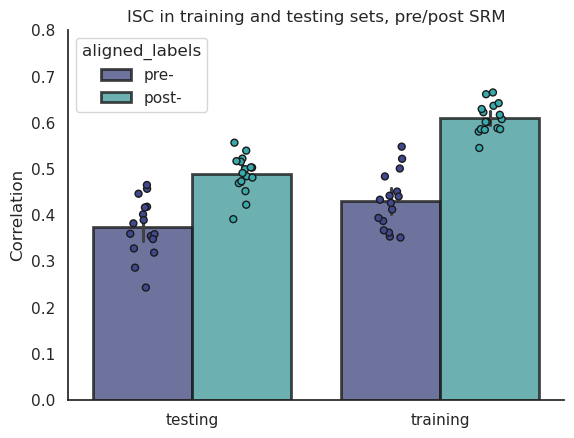

In [28]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=pd.DataFrame(isc_results), x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title='ISC in training and testing sets, pre/post SRM')
sns.despine()

Something else we can do with SRM is tune the number of shared responses learned, with cross-validation. This is how it would work:

In [29]:
# Iterate through feature hyperparameter and compute ISC on the training data
K_values = np.arange(5, 100, 5)
average_iscs = np.zeros(len(K_values))
for i,k in enumerate(K_values):
    srm_model = srm.SRM(features=k)
    srm_model.fit([d.T for d in training_dss])
    # now score ISC on the training data
    dss_srm = srm_model.transform([d.T for d in training_dss])
    corr = np.mean(run_isc(dss_srm))
    average_iscs[i] = corr

# Choose the K that resulted in the highest isc
maxx = np.argmax(average_iscs)
best_k = K_values[maxx]
srm_model = srm.SRM(features=k)
srm_model.fit([d.T for d in training_dss])
srm_training_dss = srm_model.transform([d.T for d in training_dss])
srm_testing_dss = srm_model.transform([d.T for d in testing_dss])

# Evaluate intersubject correlations
training_isc = run_isc(training_dss)
testing_isc = run_isc(testing_dss)
srm_training_isc = run_isc(srm_training_dss)
srm_testing_isc = run_isc(srm_testing_dss)

# Average results to get one per subject per split
r0 = np.mean(training_isc,axis=1)
r1 = np.mean(testing_isc, axis=1)
r2 = np.mean(srm_training_isc, axis=1)
r3 = np.mean(srm_testing_isc, axis=1)
isc_results = {'scores': np.concatenate([r0,r1,r2,r3]), 
               'participants':np.tile(np.arange(1,17), 4),
              'aligned':np.concatenate([np.zeros(16), np.zeros(16), np.ones(16), np.ones(16)]), 
              'training':np.concatenate([np.ones(16), np.zeros(16), np.ones(16), np.zeros(16)])}
isc_results['aligned_labels'] = ['pre-' if v == 0 else 'post-' for v in isc_results['aligned']]

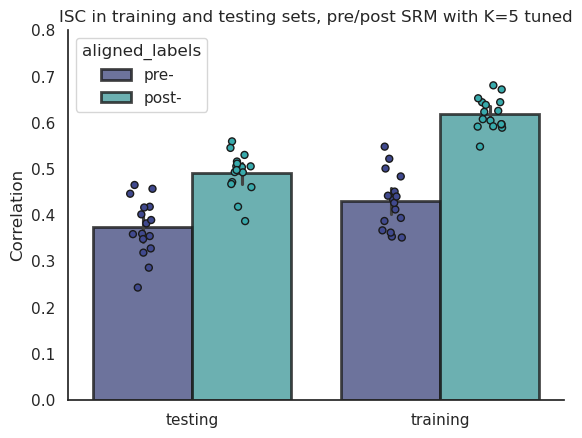

In [30]:
sns.set(context='notebook', style='white')
g=sns.barplot(data=isc_results, x='training', 
              y='scores', hue='aligned_labels',
              palette='mako',alpha=0.8, 
              edgecolor='k', linewidth=2)
g=sns.stripplot(data=isc_results, x='training', y='scores', 
                dodge=True, hue='aligned_labels',
                legend=False, palette='mako', edgecolor='k', 
                linewidth=1, )
g.set(xticks=[0,1],xticklabels=['testing','training'], ylim=[0,0.8], xlabel='', 
      ylabel='Correlation', title=f'ISC in training and testing sets, pre/post SRM with K={best_k} tuned')
sns.despine()

In [28]:
### and we can also again run the between-subject classification, which will take a hot moment

In [ ]:
df1=pd.DataFrame(columns=['fold','aligned','accuracy'])
label_subset = labels[n_trs//2:]
training_labels_orig = np.tile(label_subset, 15)
label_subset1=label_subset#np.tile(label_subset, 4)
folder=LeaveOneOut()#KFold(n_splits=4)
testing_dss_aligned=np.array(testing_dss_aligned)
testing_dss = np.array(testing_dss)
_, ns, nv = testing_dss.shape
kernel='rbf'
C=10
# between subject classification analysis 
for i,(train_idx,test_idx) in enumerate(folder.split(np.arange(16))):
    print(f'Fold {i}, testing on: {test_idx}')
    
    clf_training_aligned, clf_testing_aligned = testing_dss_aligned[train_idx].reshape(len(train_idx)*ns,nv), testing_dss_aligned[test_idx].reshape(len(test_idx)*ns, nv)
    clf_training_aligned, training_labels = random_upsample_train_data(clf_training_aligned, training_labels_orig)

    svc_align = svm.SVC(C=C, kernel=kernel, class_weight='balanced')
    svc_align.fit(clf_training_aligned, training_labels)
    acc_align = svc_align.score(clf_testing_aligned, label_subset1)
    df1.loc[len(df1)] = {'fold':i, 'aligned':'post-', 'accuracy':acc_align}
    print(f'aligned={np.round(acc_align,3)}')
    
    

## Aligning RS-fMRI

In [31]:
loaded_data=load_rsfmri(20, seed_region=10)
parcellated_data, region_data = np.array(loaded_data['parcellated_all']), np.array(loaded_data['region_all'])
n_timepoints = region_data.shape[1]
parcellated_split_0, region_split_0 = parcellated_data[:, :n_timepoints//2, :], region_data[:, :n_timepoints//2, :]
parcellated_split_1, region_split_1 = parcellated_data[:, n_timepoints//2:, :], region_data[:, n_timepoints//2:, :]

cnx_split0 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T).T) for p,r in zip(parcellated_split_0, region_split_0)]
cnx_split1 = [np.nan_to_num(compute_connectivity_matrix(p.T, r.T).T) for p,r in zip(parcellated_split_1, region_split_1)]
print(np.shape(cnx_split0), np.shape(cnx_split1))

(20, 67, 150) (20, 67, 150)


In [32]:
# Train SRM on the first half and transform the second half, and vice-versa

cnx_split1T = np.array([c for c in cnx_split1])
cnx_split0T = np.array([c for c in cnx_split0]) # reshape 

model_split0 = srm.SRM(features=20)
model_split0.fit(cnx_split0T)

aligned_cnx_split1 = model_split0.transform(cnx_split1T)
aligned_cnx_split1 = np.array([s for s in aligned_cnx_split1])


model_split1 = srm.SRM(features=20)
model_split1.fit(cnx_split1T)

aligned_cnx_split0 = model_split1.transform(cnx_split0T)
aligned_cnx_split0 = np.array([s for s in aligned_cnx_split0])

In [33]:
# evaluate reliability of connectivity across split-halves
def individual_differences_reliability(cnx0, cnx1):
    pcorr0 = compute_pairwise_corr(cnx0)
    pcorr1 = compute_pairwise_corr(cnx1)
    return np.corrcoef(pcorr0, pcorr1)[0,1]
   
def compute_pairwise_corr(c):
    n,s,t=np.array(c).shape
    c = np.array(c).reshape(n,s*t)
    corrs = pdist(c, 'correlation')
    return corrs

[Text(0.5, 1.0, 'Post-SRM corr. diff. split 1; rel = 0.591')]

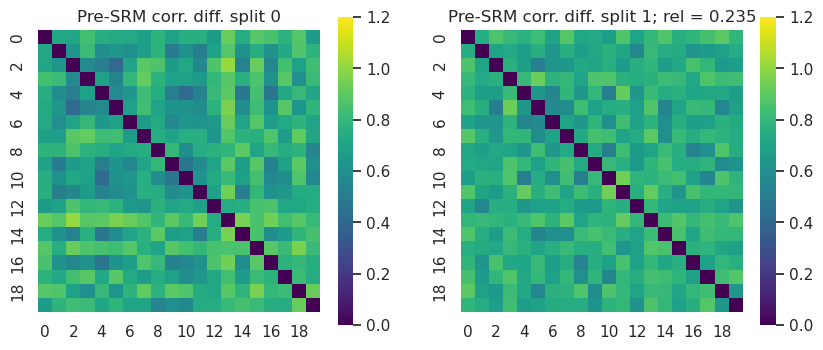

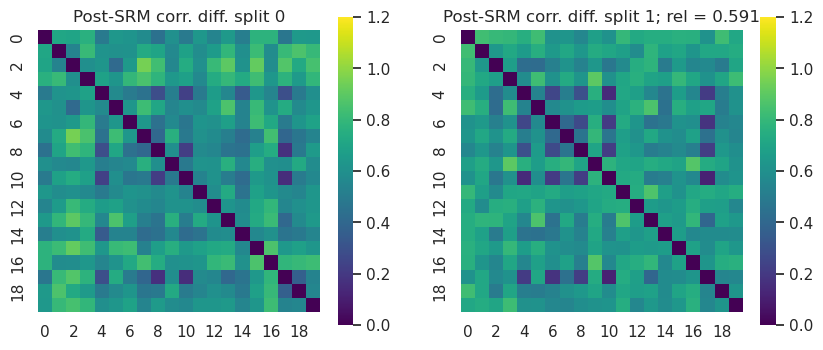

In [34]:
# Running reliability of individual differences across the split halves of data, 
# before and after hyperalignment

pcorr0 = squareform(compute_pairwise_corr(cnx_split0))
pcorr1 = squareform(compute_pairwise_corr(cnx_split1))

fig,ax = plt.subplots(1,2,figsize=(10,4))
r=individual_differences_reliability(cnx_split0, cnx_split1)
g=sns.heatmap(pcorr0, ax=ax[0], vmin=0, vmax=1.2, cmap='viridis', square=True)
g.set(title='Pre-SRM corr. diff. split 0')
g=sns.heatmap(pcorr1, ax=ax[1], vmin=0, vmax=1.2, cmap='viridis', square=True)
g.set(title=f'Pre-SRM corr. diff. split 1; rel = {np.round(r,3)}')


apcorr0 = squareform(compute_pairwise_corr(aligned_cnx_split0))
apcorr1 = squareform(compute_pairwise_corr(aligned_cnx_split1))
r=individual_differences_reliability(aligned_cnx_split0, aligned_cnx_split1)
fig,ax = plt.subplots(1,2,figsize=(10,4))
g=sns.heatmap(apcorr0, ax=ax[0], vmin=0, vmax=1.2, cmap='viridis', square=True)
g.set(title=f'Post-SRM corr. diff. split 0')
g=sns.heatmap(apcorr1, ax=ax[1], vmin=0, vmax=1.2, cmap='viridis', square=True)
g.set(title=f'Post-SRM corr. diff. split 1; rel = {np.round(r,3)}')
